In [1]:
import sys
import os
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import gseapy as gp
import decoupler as dc

# Append the src directory to the path
current_dir = os.getcwd()
src_dir = os.path.abspath(os.path.join(current_dir, '..', 'src'))
if src_dir not in sys.path:
    sys.path.append(src_dir)

working_dir = "/ocean/projects/cis240075p/asachan/datasets/TA_muscle/seurat_outs/tables"

/ocean/projects/cis240075p/asachan/.conda/envs/decoupler/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Get the DEGs

In [8]:
########## file paths ##########

#fast2b
female_fast2b_path = os.path.join(working_dir, "Female_FastIIB_unfiltered_KO_DEGs.csv")
male_fast2b_path = os.path.join(working_dir, "Male_Fast IIB_unfiltered_KO_DEGs_nmt.csv")
#fast2x
female_fast2x_path = os.path.join(working_dir, "Female_FastIIX_unfiltered_KO_DEGs.csv")
male_fast2x_path = os.path.join(working_dir, "Male_Fast IIX_unfiltered_KO_DEGs_nmt.csv")
# #faps
# female_faps_path = os.path.join(working_dir, "Female_FAPs_unfiltered_KO_DEGs_nmt.csv")
# male_faps_path = os.path.join(working_dir, "Male_FAPs_unfiltered_KO_DEGs_nmt.csv")
# #musc
# female_musc_path = os.path.join(working_dir, "Female_Skeleton MuSc_unfiltered_KO_DEGs_nmt.csv")
# male_musc_path = os.path.join(working_dir, "Male_Skeleton MuSc_unfiltered_KO_DEGs_nmt.csv")


In [49]:
############ load cell-type specific DEGs ############

path_female_degs = female_fast2b_path
path_male_degs = male_fast2b_path
female_degs = pd.read_csv(path_female_degs, header=0)
female_degs.rename(columns={female_degs.columns[0]: 'gene_name'}, inplace=True)
male_degs = pd.read_csv(path_male_degs, header=0)
male_degs.rename(columns={male_degs.columns[0]: 'gene_name'}, inplace=True)

In [19]:
def create_ranked_genelist(deg_df, log2fc_col='avg_log2FC', pval_col='p_val_adj', gene_col='gene_name', min_pval=1e-300):
    """
    Create a ranked gene list based on signed log2FC * -log10(adjusted p-value)
    """
    df = deg_df.copy()
    # Clip p-values
    df[pval_col] = df[pval_col].clip(lower=min_pval)
    # Calculate components and final score
    df['neg_log10_pval'] = -np.log10(df[pval_col])
    df['ranking_score'] = df[log2fc_col] * df['neg_log10_pval']
    # Sort by absolute ranking score
    ranked_df = df.sort_values('ranking_score', ascending=False)
    # Create final DataFrame with gene names as columns
    ranked_list = ranked_df.set_index(gene_col)[['ranking_score']].T
    return ranked_list

In [21]:
gsea_female_degs = create_ranked_genelist(female_degs)
gsea_male_degs = create_ranked_genelist(male_degs)

In [50]:
print(gsea_female_degs['Atp2a1'])

ranking_score    43.792006
Name: Atp2a1, dtype: float64


## Load the genesets of interest (mouse)

In [22]:
# load msigDB all genesets for mice
msigdb_mice_gmt = "/ocean/projects/cis240075p/asachan/datasets/gene_sets/mouse/msigdb.v2024.1.Mm.symbols.gmt"

In [23]:
from pathlib import Path

def gmt_to_decoupler(pth: Path) -> pd.DataFrame:
    """Parse a gmt file to a decoupler pathway dataframe."""
    from itertools import chain, repeat

    pathways = {}

    with Path(pth).open("r") as f:
        for line in f:
            name, _, *genes = line.strip().split("\t")
            pathways[name] = genes

    return pd.DataFrame.from_records(
        chain.from_iterable(zip(repeat(k), v) for k, v in pathways.items()),
        columns=["geneset", "genesymbol"],
    )

In [29]:
msigdb_mice = gmt_to_decoupler(msigdb_mice_gmt)
# Count unique genesets
n_unique_genesets = msigdb_mice['geneset'].nunique()
print(f"Number of unique genesets: {n_unique_genesets}")

Number of unique genesets: 16059


In [30]:
# Filtering genesets to match behaviour of fgsea
geneset_size = msigdb_mice.groupby("geneset").size()
# Index object of genesets that have more than 15 and less than 500 genes
gsea_genesets = geneset_size.index[(geneset_size > 15) & (geneset_size < 500)]

### Select Pathways related to mitochondrial function

In [73]:
# Create a list of keywords you're interested in
keywords = [
    'OXIDATIVE_PHOSPHORYLATION',      # For oxidative phosphorylation
    'TCA',         # For TCA cycle
    'GLUTAMINE',   # For glutamine metabolism
    'CALCIUM',     # For calcium signaling
    'APOPTOSIS'    # For apoptosis
]

selected_pathways = [
    pathway for pathway in gsea_genesets
    if any(keyword.lower() in pathway.lower() for keyword in keywords) 
    and (pathway.startswith('GOBP_') or pathway.startswith('REACTOME_'))
]

display(len(selected_pathways))

66

In [68]:
# find the geneset that contains the gene 'Atp2a1'
serca_genesets = []
for geneset in selected_pathways:
    if 'Atp2a1' in msigdb_mice[msigdb_mice['geneset'] == geneset]['genesymbol'].values:
        serca_genesets.append(geneset)
        break

display(serca_genesets)

['GOBP_CALCIUM_ION_HOMEOSTASIS']

In [83]:
scores, norm, pvals = dc.run_gsea(
    gsea_female_degs,
    msigdb_mice[msigdb_mice["geneset"].isin(selected_pathways)],
    source="geneset",
    target="genesymbol",
)

gsea_results = (
    pd.concat({"score": scores.T, "norm": norm.T, "pval": pvals.T}, axis=1)
    .droplevel(level=1, axis=1)
    .sort_values("pval")
)

In [84]:
def get_top_pathway_per_keyword(gsea_results, keywords):
    """
    Get the top (highest absolute NES) GOBP pathway for each keyword
    Returns a dictionary with original pathway names
    """
    top_paths = {}
    
    for keyword in keywords:
        print(f"\nSearching for keyword: {keyword}")
        # Filter for pathways containing this keyword
        matching_paths = gsea_results[
            gsea_results.index.str.contains(keyword, case=False)
        ]
        
        print(f"Found {len(matching_paths)} matching pathways")
        if not matching_paths.empty:
            print(f"Top matching pathway: {matching_paths.index[0]}")
            pathway_name = matching_paths.index[0]
            top_paths[pathway_name] = matching_paths.iloc[0]
        else:
            print(f"No pathways found for keyword: {keyword}")
            
        # Print first few matching pathways for debugging
        if len(matching_paths) > 0:
            print("First few matching pathways:")
            print(matching_paths.index[:3].tolist())
    
    # Convert to DataFrame
    result_df = pd.DataFrame(top_paths).T
    
    return result_df

# Apply the filter with more flexible keywords
keywords = [
    'OXIDATIVE_PHOSPHORYLATION',
    'TCA',
    'GLUTAMINE',
    'CALCIUM',
    'APOPTOSIS'
]

keyword_top_pathways = get_top_pathway_per_keyword(gsea_results, keywords)

# Display results
display(keyword_top_pathways)


Searching for keyword: OXIDATIVE_PHOSPHORYLATION
Found 2 matching pathways
Top matching pathway: GOBP_OXIDATIVE_PHOSPHORYLATION
First few matching pathways:
['GOBP_OXIDATIVE_PHOSPHORYLATION', 'GOBP_REGULATION_OF_OXIDATIVE_PHOSPHORYLATION']

Searching for keyword: TCA
Found 1 matching pathways
Top matching pathway: REACTOME_CITRIC_ACID_CYCLE_TCA_CYCLE
First few matching pathways:
['REACTOME_CITRIC_ACID_CYCLE_TCA_CYCLE']

Searching for keyword: GLUTAMINE
Found 2 matching pathways
Top matching pathway: GOBP_GLUTAMINE_FAMILY_AMINO_ACID_METABOLIC_PROCESS
First few matching pathways:
['GOBP_GLUTAMINE_FAMILY_AMINO_ACID_METABOLIC_PROCESS', 'GOBP_GLUTAMINE_FAMILY_AMINO_ACID_CATABOLIC_PROCESS']

Searching for keyword: CALCIUM
Found 36 matching pathways
Top matching pathway: GOBP_POSITIVE_REGULATION_OF_CALCIUM_MEDIATED_SIGNALING
First few matching pathways:
['GOBP_POSITIVE_REGULATION_OF_CALCIUM_MEDIATED_SIGNALING', 'GOBP_CALCIUM_ION_TRANSMEMBRANE_IMPORT_INTO_CYTOSOL', 'GOBP_CALCIUM_ION_TRANSMEMB

,score,norm,pval
GOBP_OXIDATIVE_PHOSPHORYLATION,0.889383,1.460188,0.023609
REACTOME_CITRIC_ACID_CYCLE_TCA_CYCLE,0.384570,0.565812,0.907216
GOBP_GLUTAMINE_FAMILY_AMINO_ACID_METABOLIC_PROCESS,0.834394,1.242046,0.226891
GOBP_POSITIVE_REGULATION_OF_CALCIUM_MEDIATED_SIGNALING,-0.876729,-1.395494,0.053498
REACTOME_APOPTOSIS,0.527164,0.794575,0.712766


In [ ]:
# get the -log10(pval) of the keyword_top_pathways
keyword_top_pathways['p_val_transformed'] = -np.log10(keyword_top_pathways['pval'])
display(keyword_top_pathways)



## Plotting the enrichment results

In [14]:
from gseapy.scipalette import SciPalette
sci = SciPalette()
NbDr = sci.create_colormap()

/ocean/projects/cis240075p/asachan/.conda/envs/czi/lib/python3.10/site-packages/gseapy/plot.py:694: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/ocean/projects/cis240075p/asachan/.conda/envs/czi/lib/python3.10/site-packages/gseapy/plot.py:694: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(


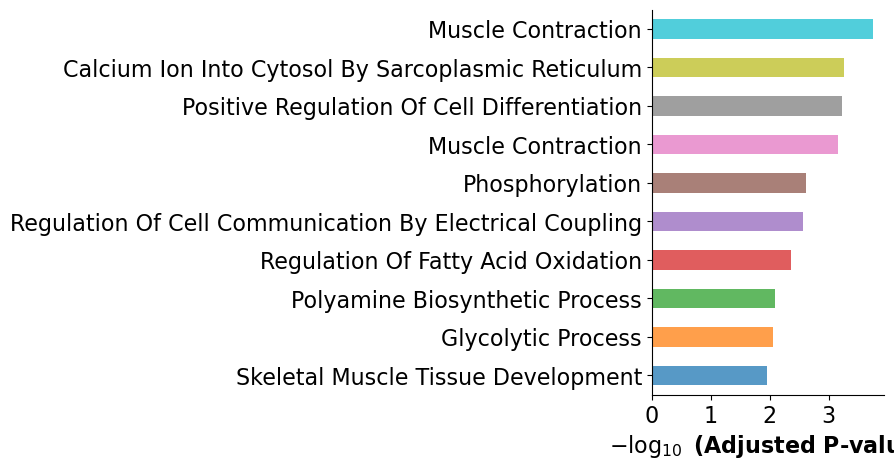

In [ ]:
# Create color mapping
ax = gp.barplot(pathway_enrichment_results, 
                figsize=(3,5),
                title="",
                color=NbDr, 
                cutoff=1)